In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Importing libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Reading the file

In [4]:
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
df_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [5]:
df_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#let separe the target column of the train data
y_train = df_train['label']
df_train.drop(columns = 'label',inplace=True)


In [7]:
number_names = y_train.unique()
number_names

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

# Preprocessing the data

## Notes

Each row it's a picture. It means we have 28000 pictures(rows), and the label indicates what type of number it corresponds (numbers between 0 and 9). As mentioned in the dataset each image has a size of 28x28 pixels, that's why we have 784 columns. 

## How to see pictures if my pictures are rows

As mentioned before you have an array a one-dimesional data structure, a digital picture is a two dimensional data structure, so in order to see it you need to reshape it as shown below

In [8]:
# Here with the iloc we choose the 5 file, then we transform it to a np array, to finally reshape it
image1 = np.array(df_train.iloc[5]).reshape((28, 28))

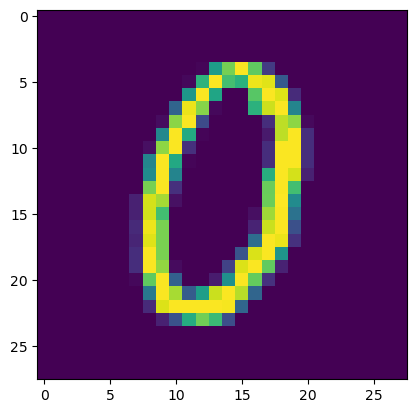

In [9]:
plt.imshow(image1)

If we want to see the image 

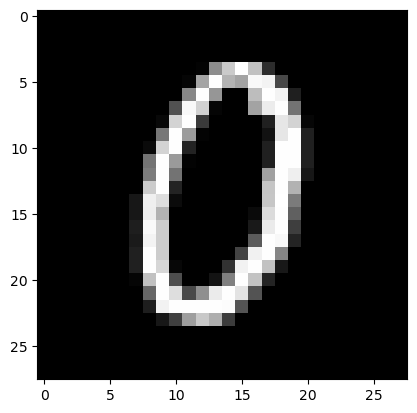

In [10]:
plt.imshow(image1,cmap='gray')

Image should be normalize for an optimal solution. This is due the deep learning algorithm, because normalize numbers reduce the complex of the machine leaning method and also the time is reduced. The max value of a an image (in any chanel) is 255.

Then we proceed to normalize all the images and to add it to other dataframe.

In [11]:
df_train_normalized =  df_train / 255
df_test_normalized =  df_test / 255

In [12]:
print("Max value for image not normalized: " + str(df_train.iloc[0].max()))
print("Max value for image normalized: " + str(df_train_normalized.iloc[0].max()))

Max value for image not normalized: 255
Max value for image normalized: 1.0


Here we need to reshape the photos to its originial resize. Remember that images were registers with shape (784,1), now the CNN needs 28*28 images

In [13]:
df_train_normalized = df_train_normalized.values.reshape(-1,28,28,1)
df_test_normalized = df_test_normalized.values.reshape(-1,28,28,1)

# Fitting the model

For fitting the model it's going to be used a sequential model. This model is quite good if the dataset are images.

## Creating the model

In this section it's specified the type of method we are using. In adition we declare the layers that this method contains. CNN consist of 3 types of layer: 

- input layer
- hidden layer 
- output layer

In [14]:
len_num_classes = len(number_names)

model = Sequential([
  #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape = (28,28,1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len_num_classes)
])

## Compiling the model 

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.build()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

# Training the model

In [18]:
epochs=10
model_history = model.fit(
    df_train_normalized,
    y_train,
    batch_size=128,
    epochs=epochs,
    validation_split = 0.2
)

Epoch 1/10
263/263 [==============================] - 15s 53ms/step - loss: 0.3929 - accuracy: 0.8844 - val_loss: 0.1031 - val_accuracy: 0.9682
Epoch 2/10
263/263 [==============================] - 13s 51ms/step - loss: 0.0871 - accuracy: 0.9734 - val_loss: 0.0937 - val_accuracy: 0.9711
Epoch 3/10
263/263 [==============================] - 14s 53ms/step - loss: 0.0604 - accuracy: 0.9813 - val_loss: 0.0594 - val_accuracy: 0.9792
Epoch 4/10
263/263 [==============================] - 13s 51ms/step - loss: 0.0464 - accuracy: 0.9856 - val_loss: 0.0469 - val_accuracy: 0.9846
Epoch 5/10
263/263 [==============================] - 14s 53ms/step - loss: 0.0363 - accuracy: 0.9885 - val_loss: 0.0465 - val_accuracy: 0.9861
Epoch 6/10
263/263 [==============================] - 13s 51ms/step - loss: 0.0315 - accuracy: 0.9902 - val_loss: 0.0552 - val_accuracy: 0.9831
Epoch 7/10
263/263 [==============================] - 14s 52ms/step - loss: 0.0262 - accuracy: 0.9917 - val_loss: 0.0343 - val_accuracy:

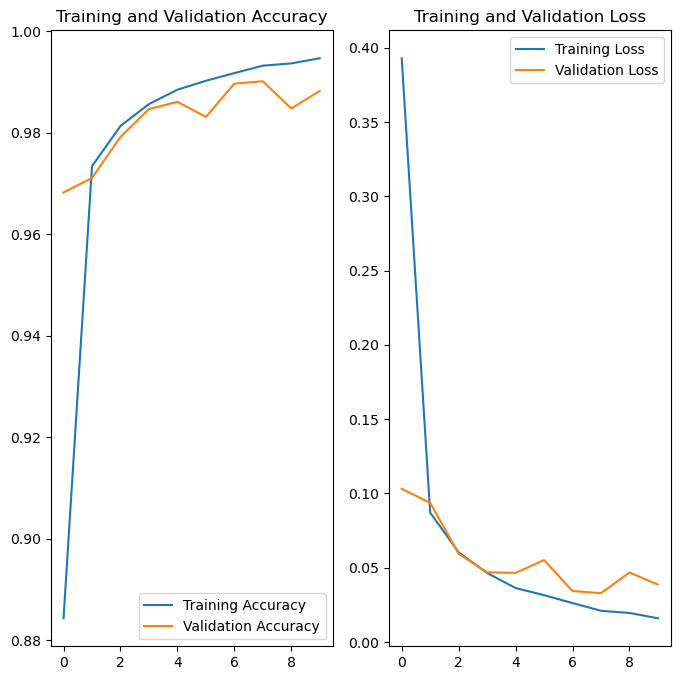

In [19]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Confussion matrix

Here you can see the confussion matrix of the model. First we need to split the data into train and test.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_normalized, y_train,
                                                    test_size = 0.2, #80% datos de entrenamiento, 20% prueba
                                                    stratify = y_train)

For the confusion matriz use the code below. Note the process to predict using a sequential method

263/263 [==============================] - 2s 6ms/step


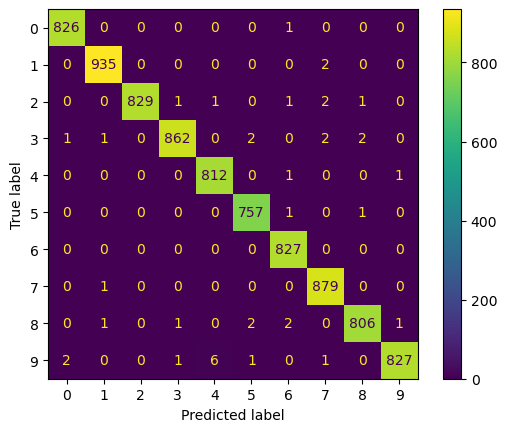

In [21]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

#Here we predict the clases. To predict the clasess the code below must be followed according the tensor Flow 2.5.x
y_pred = model.predict(X_test)
classes_pred =np.argmax(y_pred,axis=1)

confusion_matrix = metrics.confusion_matrix(y_test, classes_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2,3,4,5,6,7,8,9])
cm_display.plot()
plt.show()

# Doing predictions

In [22]:
df_test_normalized.shape[0]

28000

In [23]:
y_pred = model.predict(df_test_normalized)
classes_pred =np.argmax(y_pred,axis=1)
data = {'ImageId': range(1,df_test_normalized.shape[0]+1),
        'Label': classes_pred }
predicciones = pd.DataFrame(data).set_index('ImageId')
predicciones.to_csv('/kaggle/working/out.csv')
predicciones

875/875 [==============================] - 5s 6ms/step


,Label
ImageId,
1,2
2,0
3,9
4,9
5,3
...,...
27996,9
27997,7
27998,3


# Working on choosen model